# AR=1.3 trial counts, tracks, and dendrogram

This combines previous figs from notebooks `fig_trial_counts_track.ipynb` and `fig_clustering_dendrogram.ipynb`.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle

In [2]:
from pp_utils.core import generate_data_path_dict
from pp_utils.file_handling import df_main_loader
from pp_utils.track_features import get_feature_array

## Set paths and load main info df

In [3]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and figure path

In [4]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [5]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

### Load main dataframe

In [6]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load full tracks

In [7]:
# full tracks for usable trials
with open(output_path / "track_all.pickle", "rb") as filein:
    df_track_all = pickle.load(filein)

### Load track portion

In [8]:
# track portions used for clustering
with open(output_path / "track_portion_all.pickle", "rb") as filein:
    df_track_portion_all = pickle.load(filein)

### Set up position-angle strings

In [9]:
TARGET_ANGLE_STR_TC = ['TC1', 'TC2', 'TC3', 'TC4']
TARGET_ANGLE_STR_CT = ['CT1', 'CT2', 'CT3', 'CT4']
TARGET_ANGLE_STR = TARGET_ANGLE_STR_TC + TARGET_ANGLE_STR_CT

In [10]:
TARGET_ANGLE_STR_NEW = [
    'R+/0', 'R+/45', 'R+/90', 'R+/135',
    'L+/0', 'L+/45', 'L+/90', 'L+/135',
]

## Find all usable trials

Usable trials should contain:
- `df_main['TRIAL_TO_INCLUDE'] = 'Y'` (deemed unusable due to various data collection issues)
- `TrialProcessor.trial_usable = True` (has usable data from all systems)

In [11]:
tp_data_usable = []
for trial_idx in df_main.index:
    # Load TrialProcessor object
    tp_obj_fname = tp_path / f"trial_{trial_idx:03d}.pickle"
    with open(tp_obj_fname, "rb") as filein:
        tp = pickle.load(filein)
        
    # Check if tp usable
    tp_data_usable.append(tp.trial_usable)

In [12]:
df_main["tp_data_usable"] = tp_data_usable

In [13]:
df_main["trial_usable_combine"] = df_main.apply(
    lambda x: (x["TRIAL_TO_INCLUDE"] == "Y") and x["tp_data_usable"], axis=1
)

Check the difference between the 2 criteria:

In [14]:
c1 = set(df_main[df_main["TRIAL_TO_INCLUDE"] == "Y"].index)

In [15]:
c2 = set(df_main[df_main["tp_data_usable"]].index)

In [16]:
c1.difference(c2)

set()

In [17]:
c2.difference(c1)

{9, 10, 13, 46, 152, 209, 210}

In [18]:
# Check trials that are in the difference set
for trial_idx in c2.difference(c1):
    print(df_main.iloc[trial_idx]["fname_prefix"], df_main.iloc[trial_idx]["SPHEROID"])

20190625_s2_t2 L
20190625_s2_t3 L
20190625_s2_t6 L
20190626_s3_t1 L
20190703_s3_t6 M
20190703_s3_t7 M
20190702_s1_t1 M


## Plot executed + usable trials

In [19]:
# Bar color - hatch pattern
correct_usable = [np.ones(3)*220/255, ""]
correct_discard = [np.ones(3)*220/255, ".."]
incorrect_usable = [np.ones(3)*150/255, ""]
incorrect_discard = ["k", ""]

In [20]:
# Bar stacking sequence
color_seq = [incorrect_usable[0], incorrect_discard[0], correct_usable[0], correct_discard[0]]
hatch_seq = [incorrect_usable[1], incorrect_discard[1], correct_usable[1], correct_discard[1]]
barwidth=0.6

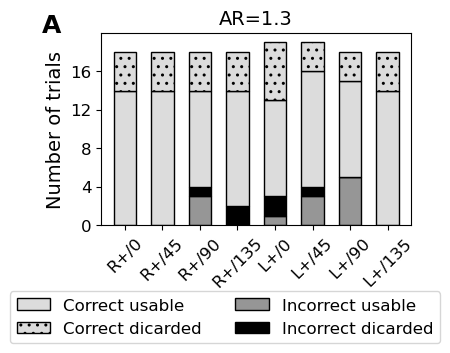

In [21]:
fig, sph_ax = plt.subplots(1, 1, figsize=(4, 2.5), facecolor="w", sharex=True)

sph_str = "M"
title_str = "AR=1.3"
panel = "A"

for seq, tca in enumerate(TARGET_ANGLE_STR):
    # Tally trials
    s_executed = df_main.loc[
        (df_main["TARGET_ANGLE"]==tca) & (df_main["SPHEROID"]==sph_str), "CHOICE"
    ].value_counts()
    s_usable = df_main.loc[
        (df_main["TARGET_ANGLE"]==tca)
        & (df_main["SPHEROID"]==sph_str)
        & df_main["trial_usable_combine"],  # usable trial from 2 criteria
        "CHOICE"
    ].value_counts()
    
    # Add index to series if no trials
    for s in [s_executed, s_usable, ]:
        if not 0 in s.index or np.isnan(s[0]):
            s[0] = 0
        if not 1 in s.index or np.isnan(s[1]):
            s[1] = 0
    s_not_usable = s_executed - s_usable
    
    # 0-wrong, 1-correct
    bar_stack_sequence = np.array(
        [s_usable[0], s_not_usable[0], s_usable[1], s_not_usable[1]]
    )
    stack_height = np.hstack((0, np.cumsum(bar_stack_sequence)))[:-1]

    for bar_height, bar_bottom, bar_hatch, bar_color in zip(
        bar_stack_sequence, stack_height, hatch_seq, color_seq
    ):
        sph_ax.bar(
            seq, bar_height, bottom=bar_bottom, color=bar_color, hatch=bar_hatch, width=barwidth, edgecolor="k"
        )
    
sph_ax.set_xticks(np.arange(8))
sph_ax.set_xticklabels(TARGET_ANGLE_STR_NEW, fontsize=12, rotation=45)
sph_ax.set_yticks(np.arange(0, 19, 4))
sph_ax.set_yticklabels(np.arange(0, 19, 4), fontsize=12)
sph_ax.set_ylabel("Number of trials", fontsize=14)
sph_ax.set_xlim(-0.63, 7.63)
sph_ax.set_title(title_str, fontsize=14)
sph_ax.set_ylim(0, 20)
sph_ax.text(-2.2, 20, panel, fontsize=18, fontweight="bold")

# Make legend
plt.bar(np.nan, np.nan, color=correct_usable[0], hatch=correct_usable[1],
        edgecolor="k", label="Correct usable")
plt.bar(np.nan, np.nan, color=correct_discard[0], hatch=correct_discard[1],
        edgecolor="k", label="Correct dicarded")
plt.bar(np.nan, np.nan, color=incorrect_usable[0], hatch=incorrect_usable[1],
        edgecolor="k", label="Incorrect usable")
plt.bar(np.nan, np.nan, color=incorrect_discard[0], hatch=incorrect_discard[1],
        edgecolor="k", label="Incorrect dicarded")

plt.legend(bbox_to_anchor=(1.12, -0.3), ncol=2, fontsize=12)

plt.show()

# fig.savefig(fig_path / "fig_trial_counts.png", dpi=150, bbox_inches="tight")

## Plot trajectories

In [22]:
def plot_track(axx, df, color, alpha=0.1, lw=2):
    axx.plot(
        df[df["before_touch"]]["DTAG_Y"],
        df[df["before_touch"]]["DTAG_X"],
        alpha=alpha, color=color, lw=lw
    )

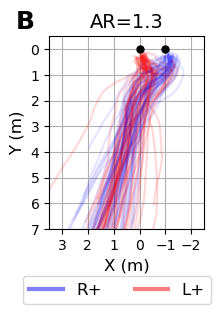

In [23]:
fig, sph_ax = plt.subplots(1, 1, figsize=(2, 2.5), facecolor="w", sharex=True)

sph_n = "M"
sph_ax = sph_ax
sph_str = "AR=1.3"
panel = "B"
line_alpha_TC = 0.1
line_alpha_CT = 0.15

df_sel = df_main[
    (df_main["SPHEROID"]==sph_n)
    & (df_main["CHOICE"]==1)
    & df_main["trial_usable_combine"]
]

for trial_idx in df_sel.index:
    df_track = df_track_all[trial_idx]
    if df_main.loc[trial_idx]["TARGET_ANGLE"][:2] == "TC":
        plot_track(sph_ax, df_track, color="b", alpha=line_alpha_TC, lw=1.6)
    else:
        plot_track(sph_ax, df_track, color="r", alpha=line_alpha_CT, lw=1.6)

# Plot target locations
sph_ax.plot(0, 0, marker="o", markersize=5, color="k")
sph_ax.plot(-1, 0, marker="o", markersize=5, color="k")

sph_ax.invert_yaxis()
sph_ax.grid()
sph_ax.set_xticks(np.arange(-2, 3.5, 1))
sph_ax.set_yticks(np.arange(9)[::-1])
sph_ax.set_ylim(7, -0.5)
sph_ax.set_xlim(3.5, -2.5)

sph_ax.set_title(sph_str, fontsize=14)
sph_ax.set_xlabel("X (m)", fontsize=12)
sph_ax.set_ylabel("Y (m)", fontsize=12)

sph_ax.text(4.8, -0.8, panel, fontsize=18, fontweight="bold")
    
plt.plot(np.nan, np.nan, color="b", label="R+", alpha=0.5, lw=3)
plt.plot(np.nan, np.nan, color="r", label="L+", alpha=0.5, lw=3)

plt.legend(bbox_to_anchor=(1.1, -0.2), ncol=2, fontsize=12)

plt.show()


## Trials with valid track portions

Assemble a dataframe consisting of only trials with valid track portions.

In [24]:
df_sel = []
for trial_idx, df in enumerate(df_track_portion_all):
    if df is not None:
        df_sel.append(df_main.loc[trial_idx])

In [25]:
df_sel = pd.concat(df_sel, axis=1).T

In [26]:
# Visual sanity check
df_sel

,DATE,SESSION,PERSONNEL,TRIAL,LEFT,RIGHT,ANGLE,SPHEROID,ASPECT_RATIO,SEQUENCE,...,CHIRP_trial_clicks_synced,LED_trial_has_LED,LED_trial_has_clutter_object,LED_trial_clicks_synced,trials_sync_both_chirp_and_LED,trials_sync_at_least_chirp_or_LED,fname_prefix,TARGET_ANGLE,tp_data_usable,trial_usable_combine
2,20190625,1,"WJ, ML",1,T,C,1,L,2.9,1,...,True,False,False,False,False,True,20190625_s1_t1,TC1,True,True
3,20190625,1,"WJ, ML",2,C,T,1,L,2.9,1,...,True,False,False,False,False,True,20190625_s1_t2,CT1,True,True
4,20190625,1,"WJ, ML",3,T,C,1,L,2.9,1,...,True,False,False,False,False,True,20190625_s1_t3,TC1,True,True
5,20190625,1,"WJ, ML",4,C,T,1,L,2.9,1,...,True,False,False,False,False,True,20190625_s1_t4,CT1,True,True
6,20190625,1,"WJ, ML",5,T,C,1,L,2.9,1,...,True,False,False,False,False,True,20190625_s1_t5,TC1,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,20190704,3,ML,6,T,C,4,M,1.3,24,...,True,True,True,True,True,True,20190704_s3_t6,TC4,True,True
241,20190704,3,ML,7,C,T,3,M,1.3,24,...,True,True,True,True,True,True,20190704_s3_t7,CT3,True,True
242,20190704,3,ML,8,T,C,1,M,1.3,24,...,True,True,True,True,True,True,20190704_s3_t8,TC1,True,True
243,20190704,3,ML,9,C,T,3,M,1.3,24,...,True,True,True,True,True,True,20190704_s3_t9,CT3,True,True


In [27]:
# Only select the AR=1.3 trials
df_sel = df_sel[df_sel["SPHEROID"]=="M"].copy()

### Check CHOICE in selected trials

In [28]:
df_sel["TARGET_ANGLE"].value_counts()

CT4    13
TC1    12
TC4    11
CT3    10
TC3    10
TC2     9
CT2     8
CT1     7
Name: TARGET_ANGLE, dtype: int64

## Assemble dict of track portion indexed by trial index

In [29]:
dict_df_track_sel = dict()
for trial_idx in df_sel.index:
    trial_name = df_sel.loc[trial_idx]["fname_prefix"]
    dict_df_track_sel[trial_name] = df_track_portion_all[trial_idx]

In [30]:
len(dict_df_track_sel)

80

## Assemble and clean feature array

In [31]:
feature_array, feature_len = get_feature_array(
    list_df_track=list(dict_df_track_sel.values()),
    feature_name=["ROSTRUM_X", "ROSTRUM_Y"],
    normalize_time=True,
)

In [32]:
feature_array.shape

(80, 101, 2)

In [33]:
feature_array_reshaped = (
    np.moveaxis(feature_array, [0, 1, 2], [2, 1, 0])
    .reshape((-1, feature_array.shape[0])).T
)

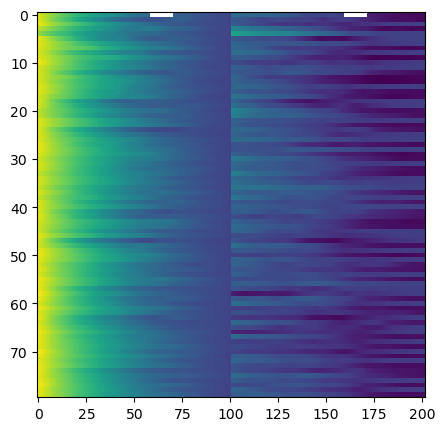

In [34]:
plt.figure(figsize=(5, 5))
plt.imshow(feature_array_reshaped, aspect="auto", interpolation="none")
plt.show()

### Remove trial with NaN entries

We can see that there are some NaN points in the feature matrix (in ROSTRUM marker and ICI). Let's find out which trials these are.

In [35]:
# Find index of the trial in the feature_array that has NaN entries
idx_trial_nan = np.argwhere(np.sum(np.isnan(feature_array_reshaped), axis=1) != 0)[0][0]
idx_trial_nan

0

In [36]:
# Find out trial to remove
trial_to_remove = list(dict_df_track_sel.keys())[idx_trial_nan]
trial_to_remove

'20190627_s2_t8'

In [37]:
# Remove NaN trial
_ = dict_df_track_sel.pop(trial_to_remove)

feature_array = np.delete(feature_array, idx_trial_nan, axis=0)
feature_array_reshaped = np.delete(feature_array_reshaped, idx_trial_nan, axis=0)

df_sel.drop(
    index=df_sel[
        df_sel["fname_prefix"] == trial_to_remove
    ].index,
    axis=1, inplace=True
)

In [38]:
# Sanity check
assert len(dict_df_track_sel) == 79
assert len(df_sel) == 79
assert feature_array.shape[0] == 79
assert feature_array_reshaped.shape[0] == 79

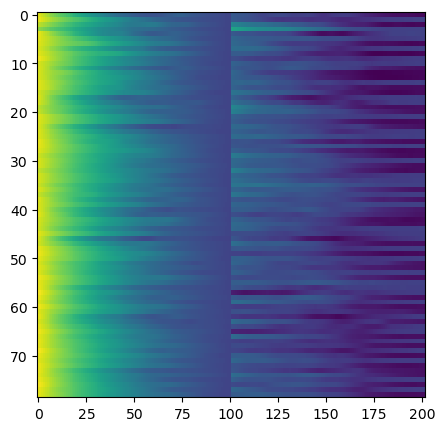

In [39]:
plt.figure(figsize=(5, 5))
plt.imshow(
    feature_array_reshaped[:,:404],  # reshape to plot 2 features together
    aspect="auto", interpolation="none"
)
plt.show()

## Plot dendrogram

In [40]:
import seaborn as sns
from matplotlib.transforms import Bbox

### Create condition colormap

In [41]:
cmap_cluster = plt.cm.get_cmap('bwr')
boundaries = np.arange(9)
norm = plt.cm.colors.BoundaryNorm(boundaries, cmap_cluster.N, clip=True)

/var/folders/1m/8nxc8r_900778tkhqfgh0nqh0000gn/T/ipykernel_83575/8497452.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_cluster = plt.cm.get_cmap('bwr')


In [42]:
TARGET_ANGLE_SEQ = np.array(["TC1", "TC2", "TC3", "TC4", "CT1", "CT2", "CT3", "CT4"])

In [43]:
color_vals8 = cmap_cluster((boundaries[:-1]+0.5)/boundaries.max())
color_vals8[-4:] = color_vals8[-4:][::-1]
color_vals8

array([[0.1254902 , 0.1254902 , 1.        , 1.        ],
       [0.37647059, 0.37647059, 1.        , 1.        ],
       [0.62745098, 0.62745098, 1.        , 1.        ],
       [0.87843137, 0.87843137, 1.        , 1.        ],
       [1.        , 0.11764706, 0.11764706, 1.        ],
       [1.        , 0.36862745, 0.36862745, 1.        ],
       [1.        , 0.61960784, 0.61960784, 1.        ],
       [1.        , 0.87058824, 0.87058824, 1.        ]])

Plot target-angle color code:

In [44]:
def plot_color_code(color_vals):
    plt.imshow(np.expand_dims(color_vals, axis=0))
    plt.xticks(np.arange(8), TARGET_ANGLE_STR_NEW, fontsize=12)
    plt.show()

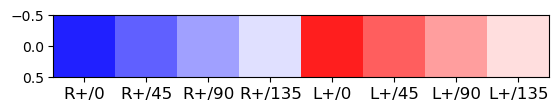

In [45]:
plot_color_code(color_vals8)

In [46]:
# TARGET_ANGLE_SEQ = np.array(["TC1", "TC2", "TC3", "TC4", "CT1", "CT2", "CT3", "CT4"])

In [47]:
tca8 = dict(zip(TARGET_ANGLE_SEQ, color_vals8))
tca8 = df_sel["TARGET_ANGLE"].map(tca8)

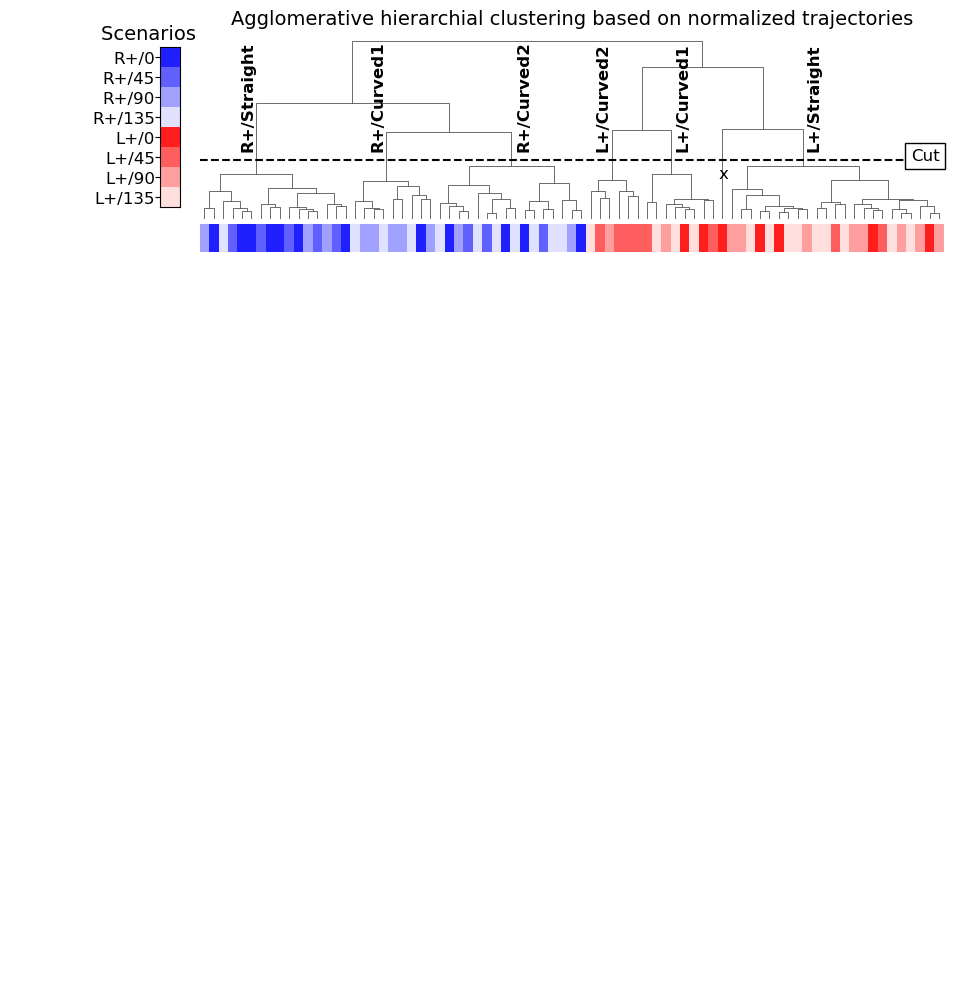

In [48]:
figsize = (10, 10)

g = sns.clustermap(
    feature_array_reshaped.T,
    method="ward",
    metric="euclidean",
    col_colors=tca8.to_numpy(),
    row_cluster=False,
    cmap="viridis",
    figsize=figsize,
    cbar_pos=[-.04, .1, .02, .3],
)

g.ax_heatmap.remove()
g.cax.remove()

g.ax_col_dendrogram.set_title(
    "Agglomerative hierarchial clustering based on normalized trajectories",
    fontsize=14
)
# g.ax_col_dendrogram.axhline(y=17, color="k", ls="--")
# g.ax_col_dendrogram.text(740, 18.5, "Cut A", fontsize=14)
g.ax_col_dendrogram.axhline(y=10, color="k", ls="--")
g.ax_col_dendrogram.text(
    755, 10, "Cut", fontsize=12,
    bbox=dict(facecolor='w', edgecolor="k")
)
g.ax_col_dendrogram.text(550.5, 7, r"x", fontsize=12)
group_height = 12
group_size = 12
group_rot = 90
g.ax_col_dendrogram.text(43, group_height, "R+/Straight",
                         fontsize=group_size, fontweight="bold", rotation=group_rot)
g.ax_col_dendrogram.text(181, group_height, "R+/Curved1",
                         fontsize=group_size, fontweight="bold", rotation=group_rot)
g.ax_col_dendrogram.text(336, group_height, "R+/Curved2",
                         fontsize=group_size, fontweight="bold", rotation=group_rot)
g.ax_col_dendrogram.text(420, group_height, "L+/Curved2",
                         fontsize=group_size, fontweight="bold", rotation=group_rot)
g.ax_col_dendrogram.text(505, group_height, "L+/Curved1",
                         fontsize=group_size, fontweight="bold", rotation=group_rot)
g.ax_col_dendrogram.text(644, group_height, "L+/Straight",
                         fontsize=group_size, fontweight="bold", rotation=group_rot)

ax_tca = g.fig.add_axes([0.165, 0.76, 0.02, 0.26])
ax_tca.imshow(np.expand_dims(color_vals8, axis=1))
ax_tca.set_xticks([])
ax_tca.set_yticks(np.arange(8))
ax_tca.set_yticklabels(TARGET_ANGLE_STR_NEW, fontsize=12)
ax_tca.tick_params(axis="y", pad=0)
ax_tca.set_title("Scenarios       ", fontsize=14, ha="center")

plt.show()

bbox = Bbox([[-110, -8],[810, 38]])
bbox = bbox.transformed(g.ax_col_dendrogram.transData).transformed(g.fig.dpi_scale_trans.inverted())

# g.savefig(fig_path / "fig_dendrogram.png", dpi=300, bbox_inches=bbox)


## Assemble figure

Need to plot the dendrogram first below because `seaborn.clustermap` creates its own fig and it is not an axis-level function.

In [49]:
import matplotlib.gridspec

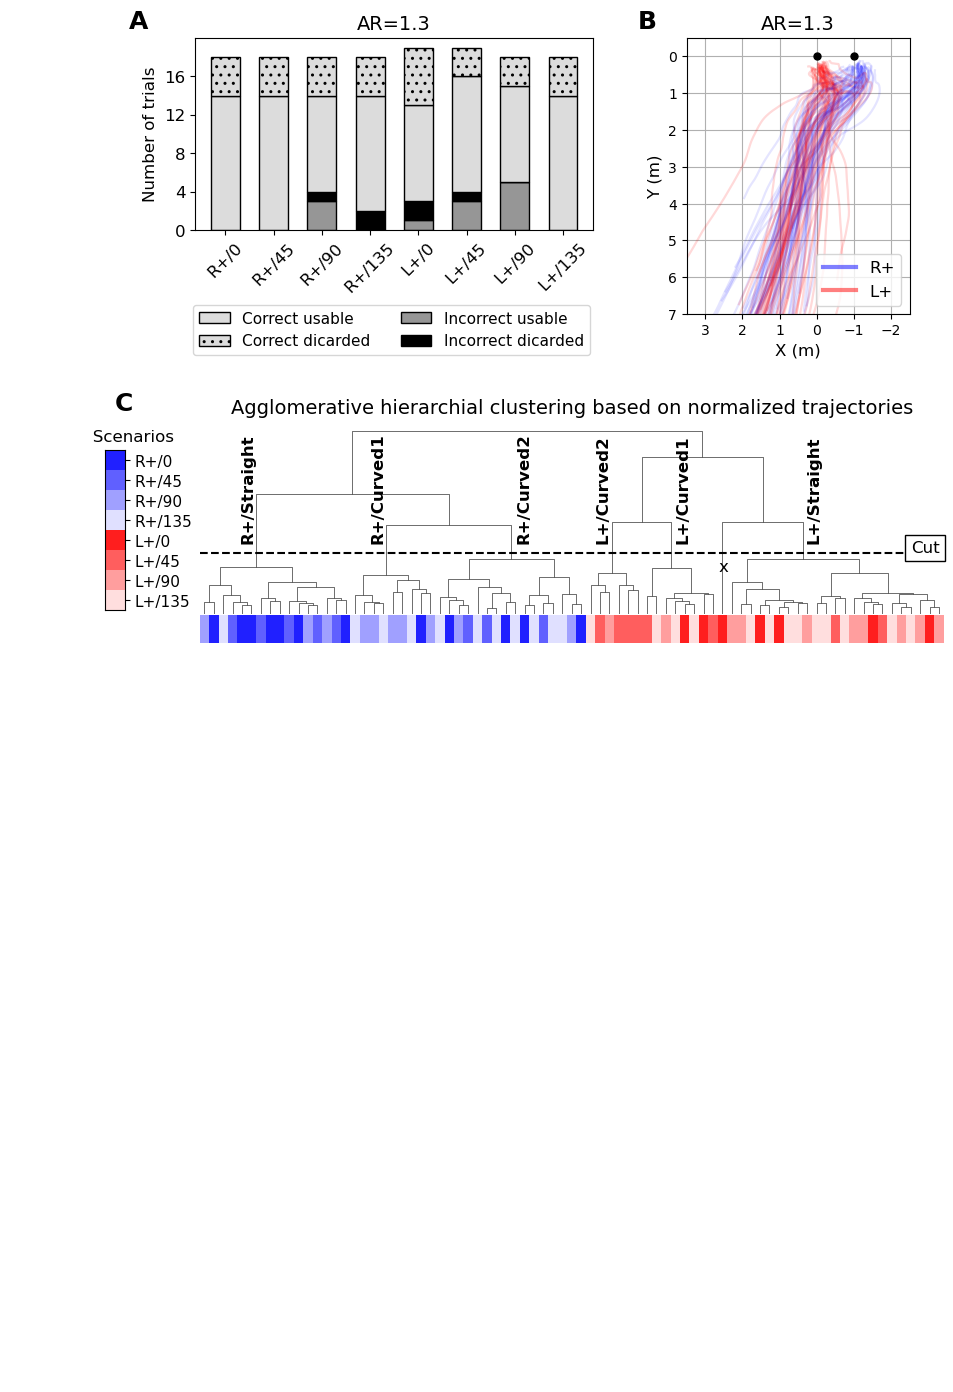

In [54]:
# Dendrogram ======================================================
g = sns.clustermap(
    feature_array_reshaped.T,
    method="ward",
    metric="euclidean",
    col_colors=tca8.to_numpy(),
    row_cluster=False,
    cmap="viridis",
    figsize=(10, 24),
    cbar_pos=[-.04, .1, .02, .3],
)

g.ax_heatmap.remove()
g.cax.remove()

g.ax_col_dendrogram.set_title(
    "Agglomerative hierarchial clustering based on normalized trajectories",
    fontsize=14
)
# g.ax_col_dendrogram.axhline(y=17, color="k", ls="--")
# g.ax_col_dendrogram.text(740, 18.5, "Cut A", fontsize=14)
g.ax_col_dendrogram.axhline(y=10, color="k", ls="--")
g.ax_col_dendrogram.text(
    755, 10, "Cut", fontsize=12,
    bbox=dict(facecolor='w', edgecolor="k")
)
g.ax_col_dendrogram.text(550.5, 7, r"x", fontsize=12)
group_height = 12
group_size = 12
group_rot = 90
g.ax_col_dendrogram.text(43, group_height, "R+/Straight",
                         fontsize=group_size, fontweight="bold", rotation=group_rot)
g.ax_col_dendrogram.text(181, group_height, "R+/Curved1",
                         fontsize=group_size, fontweight="bold", rotation=group_rot)
g.ax_col_dendrogram.text(336, group_height, "R+/Curved2",
                         fontsize=group_size, fontweight="bold", rotation=group_rot)
g.ax_col_dendrogram.text(420, group_height, "L+/Curved2",
                         fontsize=group_size, fontweight="bold", rotation=group_rot)
g.ax_col_dendrogram.text(505, group_height, "L+/Curved1",
                         fontsize=group_size, fontweight="bold", rotation=group_rot)
g.ax_col_dendrogram.text(644, group_height, "L+/Straight",
                         fontsize=group_size, fontweight="bold", rotation=group_rot)

ax_tca = g.fig.add_axes([0.11, 0.275, 0.02, 0.26])  # left, bottom, width, height
ax_tca.imshow(np.expand_dims(color_vals8, axis=1))
ax_tca.set_xticks([])
ax_tca.set_yticks(np.arange(8))
ax_tca.set_yticklabels(TARGET_ANGLE_STR_NEW, fontsize=11, ha="left")
ax_tca.yaxis.tick_right()
ax_tca.tick_params(axis="y")
ax_tca.set_title("       Scenarios", fontsize=12)

ax_tca.text(0, -2.5, "C", fontsize=18, fontweight="bold")


# Adjust axes ======================================================
# set the gridspec to only cover half of the figure
g.gs.update(top=0.45, bottom=0.05)

#create new gridspec for the right part
gs2 = matplotlib.gridspec.GridSpec(1,2, top=0.61, bottom=0.53, left=0.20, right=1)


# Trial tally ======================================================
sph_ax = g.fig.add_subplot(gs2[0, 0])
sph_str = "M"
title_str = "AR=1.3"

for seq, tca in enumerate(TARGET_ANGLE_STR):
    # Tally trials
    s_executed = df_main.loc[
        (df_main["TARGET_ANGLE"]==tca) & (df_main["SPHEROID"]==sph_str), "CHOICE"
    ].value_counts()
    s_usable = df_main.loc[
        (df_main["TARGET_ANGLE"]==tca)
        & (df_main["SPHEROID"]==sph_str)
        & df_main["trial_usable_combine"],  # usable trial from 2 criteria
        "CHOICE"
    ].value_counts()
    
    # Add index to series if no trials
    for s in [s_executed, s_usable, ]:
        if not 0 in s.index or np.isnan(s[0]):
            s[0] = 0
        if not 1 in s.index or np.isnan(s[1]):
            s[1] = 0
    s_not_usable = s_executed - s_usable
    
    # 0-wrong, 1-correct
    bar_stack_sequence = np.array(
        [s_usable[0], s_not_usable[0], s_usable[1], s_not_usable[1]]
    )
    stack_height = np.hstack((0, np.cumsum(bar_stack_sequence)))[:-1]

    for bar_height, bar_bottom, bar_hatch, bar_color in zip(
        bar_stack_sequence, stack_height, hatch_seq, color_seq
    ):
        sph_ax.bar(
            seq, bar_height, bottom=bar_bottom, color=bar_color, hatch=bar_hatch, width=barwidth, edgecolor="k"
        )
    
sph_ax.set_xticks(np.arange(8))
sph_ax.set_xticklabels(TARGET_ANGLE_STR_NEW, fontsize=12, rotation=45)
sph_ax.set_yticks(np.arange(0, 19, 4))
sph_ax.set_yticklabels(np.arange(0, 19, 4), fontsize=12)
sph_ax.set_ylabel("Number of trials", fontsize=12)
sph_ax.set_xlim(-0.63, 7.63)
sph_ax.set_title(title_str, fontsize=14)
sph_ax.set_ylim(0, 20)
sph_ax.text(-2, 21, "A", fontsize=18, fontweight="bold")

# Make legend
plt.bar(np.nan, np.nan, color=correct_usable[0], hatch=correct_usable[1],
        edgecolor="k", label="Correct usable")
plt.bar(np.nan, np.nan, color=correct_discard[0], hatch=correct_discard[1],
        edgecolor="k", label="Correct dicarded")
plt.bar(np.nan, np.nan, color=incorrect_usable[0], hatch=incorrect_usable[1],
        edgecolor="k", label="Incorrect usable")
plt.bar(np.nan, np.nan, color=incorrect_discard[0], hatch=incorrect_discard[1],
        edgecolor="k", label="Incorrect dicarded")

plt.legend(bbox_to_anchor=(1.01, -0.35), ncol=2, fontsize=11)


# Trajectory ======================================================
ax_trk = g.fig.add_subplot(gs2[0, 1])
sph_n = "M"
sph_str = "AR=1.3"
line_alpha_TC = 0.1
line_alpha_CT = 0.15

df_sel = df_main[
    (df_main["SPHEROID"]==sph_n)
    & (df_main["CHOICE"]==1)
    & df_main["trial_usable_combine"]
]

for trial_idx in df_sel.index:
    df_track = df_track_all[trial_idx]
    if df_main.loc[trial_idx]["TARGET_ANGLE"][:2] == "TC":
        plot_track(ax_trk, df_track, color="b", alpha=line_alpha_TC, lw=1.6)
    else:
        plot_track(ax_trk, df_track, color="r", alpha=line_alpha_CT, lw=1.6)

# Plot target locations
ax_trk.plot(0, 0, marker="o", markersize=5, color="k")
ax_trk.plot(-1, 0, marker="o", markersize=5, color="k")

pos_trk = ax_trk.get_position()
ax_trk.set_position(
    [pos_trk.x0+0.09, pos_trk.y0-0.035, pos_trk.width*0.56, pos_trk.height+0.035]
)  # left, bottom, width, height

ax_trk.invert_yaxis()
ax_trk.grid()
ax_trk.set_xticks(np.arange(-2, 3.5, 1))
ax_trk.set_yticks(np.arange(9)[::-1])
ax_trk.set_ylim(7, -0.5)
ax_trk.set_xlim(3.5, -2.5)

ax_trk.set_title(sph_str, fontsize=14)
ax_trk.set_xlabel("X (m)", fontsize=12)
ax_trk.set_ylabel("Y (m)", fontsize=12)

ax_trk.text(4.8, -0.75, "B", fontsize=18, fontweight="bold")
    
plt.plot(np.nan, np.nan, color="b", label="R+", alpha=0.5, lw=3)
plt.plot(np.nan, np.nan, color="r", label="L+", alpha=0.5, lw=3)

plt.legend(loc="lower right", ncol=1, fontsize=12)



# plt.show()

bbox = Bbox([[-130, -8],[810, 102]])  # left, right, bottom, top
bbox = bbox.transformed(g.ax_col_dendrogram.transData).transformed(g.fig.dpi_scale_trans.inverted())

plt.show()

g.savefig(fig_path / "fig_tally_track_dendrogram.png", dpi=300, bbox_inches=bbox)
